## Fitting with our dataset

In [20]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import os
import sys
import gepard as g # NeuralModel with Dispersion relation added 
from gepard import model, fitter, data, plots
import gepard.plots as gplot
from gepard.fits import GLO15new, AUTIpts, ALUIpts, ACpts, AULpts, ALLpts
print('Gepard version = {}'.format(g.__version__))

Gepard version = 0.9.11b0


In [22]:
import gmaster as gm
from gmaster.fits import th_KM15, th_KM10b # need KM15 for simulated data
th15 = th_KM15
from gmaster.constants import Mp2, toTeX

In [23]:
import torch
import numpy as np 
#np.set_printoptions(legacy='1.25')
import matplotlib
import matplotlib.pyplot as plt
import shelve, logging, copy
logging.basicConfig(level=logging.ERROR) 
import pandas as pd 
from scipy.integrate import quad
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.stats import norm

### To add our data files to gepard


In [24]:
sys.path.append('/Users/higuera-admin/Documents/Programs/ldrdgff/gepard/src/gepard/')

import mydatafiles
from mydatafiles import ep2epgamma

mydset = g.data.loaddata(mydatafiles)
mydset.update(g.data.loaddata(ep2epgamma))

In [25]:
# To have nice LaTeX fonts on plots
plt.rc('text', usetex=True)
params = {'text.latex.preamble' : '\n'.join([r'\usepackage{amssymb}', r'\usepackage{amsmath}'])}
plt.rcParams.update(params)

In [26]:
fitpoints = (
    g.dset.get(101, []) + g.dset.get(102, []) + g.dset.get(8, [])  
    #+ g.dset.get(81, []) + g.dset.get(94, []) + g.dset.get(95, []) + g.dset.get(96, [])
    + mydset.get(182, []) + mydset.get(192, []) 
    #+ ACpts+ AULpts + ALLpts 
    #+ mydset.get(251, [])
)   
g.describe_data(fitpoints)

npt x obs     collab  FTn    id  ref.        
----------------------------------------------
 8 x ALU     CLAS    -1     182 arxiv.org/pdf/2211.11274
 8 x ALU     CLAS    -1     192 arxiv:2211.11274
12 x ALU     CLAS    -1.0   8   arXiv:0711.4805
48 x XLUw    CLAS    -1     101 arXiv:1504.02009
48 x XUUw    CLAS    0.0    102 arXiv:1504.02009
48 x XUUw    CLAS    1.0    102 arXiv:1504.02009
----------------------------------------------
TOTAL = 172


In [28]:
# For easier manipulations we transform some datasets to pandas frames
data = mydset[192]
BSA = data.df()   # ALU by CLAS 2022
data = g.dset[102]
BSS = data.df()  # CLAS 2015
data = g.dset[101]
BSD = data.df()  # CLAS 2015

In [29]:
# Bins can be defined as ranges within the following limiting values:
tmlims = [0, 0.13, 0.18, 0.22, 0.3, 0.4, 0.5,0.7]
xilims = [0, 0.11, 0.13, 0.15, 0.17, 0.19, 0.21, 0.23, 0.26]

Text(0, 0.5, '$-t\\quad[{\\rm GeV}^2]$')

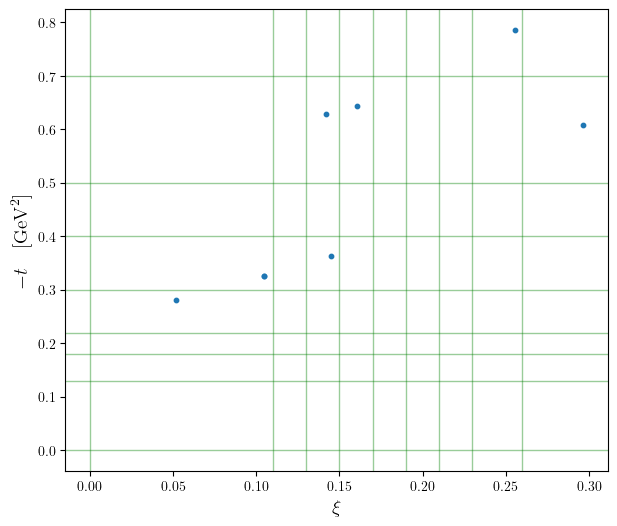

In [30]:
fig, ax = plt.subplots(figsize=[7,6])
ax.scatter(BSA.xi, BSA.tm, s=10)
for tm in tmlims:
    ax.axhline(tm, color='g', linewidth=1, alpha=0.4)
for xi in xilims:
    ax.axvline(xi, color='g', linewidth=1, alpha=0.4)
ax.set_xlabel(r'$\xi$', fontsize=14)
ax.set_ylabel(r'$-t\quad[{\rm GeV}^2]$', fontsize=14)

Text(0, 0.5, '$-t\\quad[{\\rm GeV}^2]$')

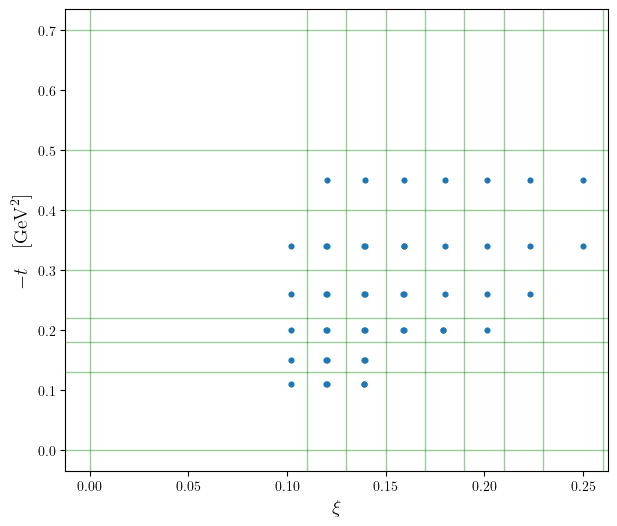

In [31]:
fig, ax = plt.subplots(figsize=[7,6])
ax.scatter(BSS.xi, BSS.tm, s=10)
for tm in tmlims:
    ax.axhline(tm, color='g', linewidth=1, alpha=0.4)
for xi in xilims:
    ax.axvline(xi, color='g', linewidth=1, alpha=0.4)
ax.set_xlabel(r'$\xi$', fontsize=14)
ax.set_ylabel(r'$-t\quad[{\rm GeV}^2]$', fontsize=14)

## Fit with NeuralModel

In [32]:
class NNTest(g.model.NeuralModel, g.eff.DipoleEFF, g.dvcs.BMK):    

    def build_net(self):
            '''Overriding the default architecture and optimizer'''
            nn_model = torch.nn.Sequential(
                    torch.nn.Linear(2, 23),
                    torch.nn.ReLU(),
                    torch.nn.Linear(23, 37),
                    torch.nn.ReLU(),
                    torch.nn.Linear(37, 19),
                    torch.nn.ReLU(),
                    torch.nn.Linear(19, len(self.output_layer))
                )
            optimizer = torch.optim.Rprop(nn_model.parameters(), lr=0.001 ) #lr=0.05 #2e-3
            return nn_model, optimizer

In [43]:
th = NNTest(output_layer=['ImH', 'ReH']) # , q2in=True) q2in not implemented yet
print(th.useDR)

None


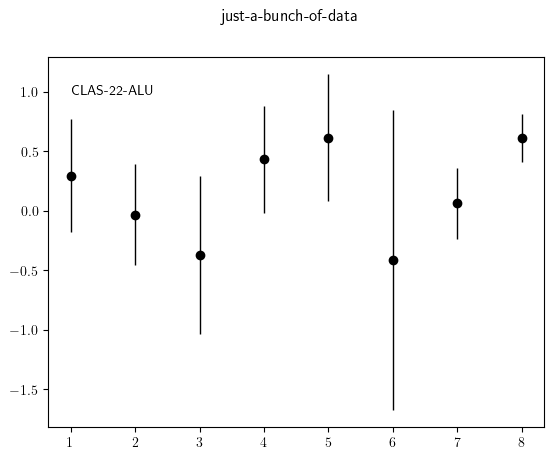

In [35]:
fig = gplot.jbod(points=mydset[192])

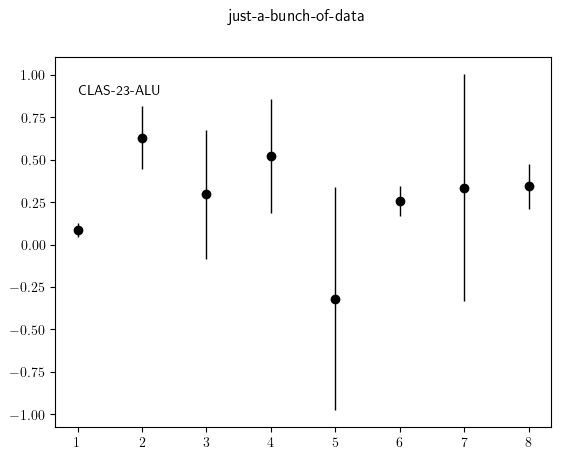

In [36]:
fig = gplot.jbod(points=mydset[182])

In [44]:
f = g.fitter.NeuralFitter(fitpoints, th, nnets=5, nbatch=10, batchlen=2, regularization='L2', lx_lambda=0.001)
f.fit()


Epoch   2: train error = 9.3340 test error = 10.2893 -
Epoch   4: train error = 9.2028 test error = 10.1200 -
Epoch   6: train error = 9.0210 test error = 9.8886 -
Epoch   8: train error = 8.7720 test error = 9.5601 -
Epoch  10: train error = 8.4227 test error = 9.0687 -
Epoch  12: train error = 7.8583 test error = 8.2809 -
Epoch  14: train error = 6.8419 test error = 6.8456 -
Epoch  16: train error = 4.9824 test error = 4.5188 -
Epoch  18: train error = 2.4308 test error = 3.3602 -
Epoch  20: train error = 1.9501 test error = 2.9608 -Net 0 --> test_err = 2.960784503364588

Epoch   2: train error = 10.2849 test error = 11.0822 -
Epoch   4: train error = 10.1480 test error = 10.8677 -
Epoch   6: train error = 9.9432 test error = 10.5630 -
Epoch   8: train error = 9.6431 test error = 10.1202 -
Epoch  10: train error = 9.1915 test error = 9.4505 -
Epoch  12: train error = 8.4748 test error = 8.3612 -
Epoch  14: train error = 7.2725 test error = 6.4973 -
Epoch  16: train error = 5.1850 te

In [45]:
th.chisq(fitpoints)

(np.float64(144.36480506562683), 172, np.float64(0.9384339729578297))

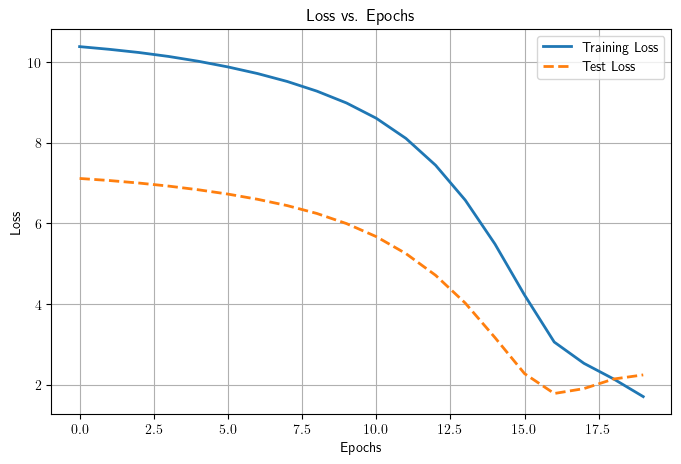

In [46]:
# Plot the results:
plt.figure(figsize=(8, 5))
plt.plot(f.history, label="Training Loss",linewidth=2.0)
plt.plot(f.test_history, label="Test Loss", linestyle="dashed",linewidth=2.0)
plt.xlabel("Epochs") #Epochs in nbatch length
plt.ylabel("Loss")
plt.title("Loss vs. Epochs")
plt.legend()
plt.grid()
plt.show()

### Just a bunch of data with mydataset

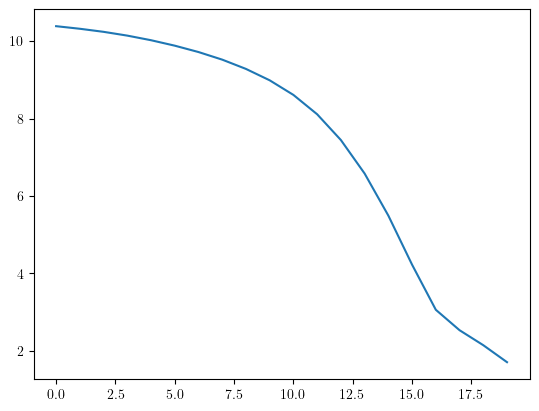

Fit on CLAS data


In [47]:
plt.figure()
plt.plot(f.history)
plt.show()
th.name = "Fit on CLAS data"
print(th.name)

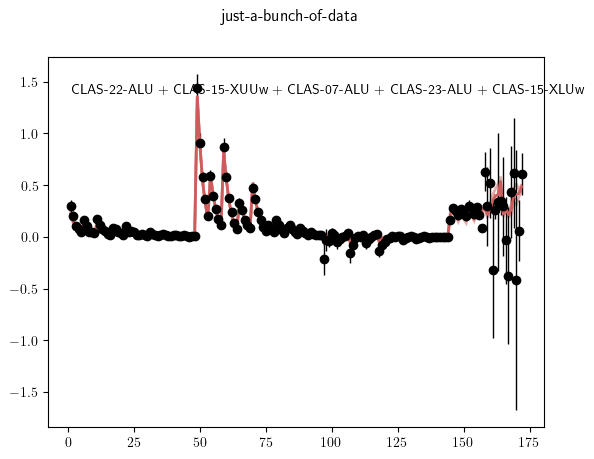

In [48]:
fig = gplot.jbod(points=fitpoints, lines=[th], bands=[th])

### CFFs plots in the no DR case

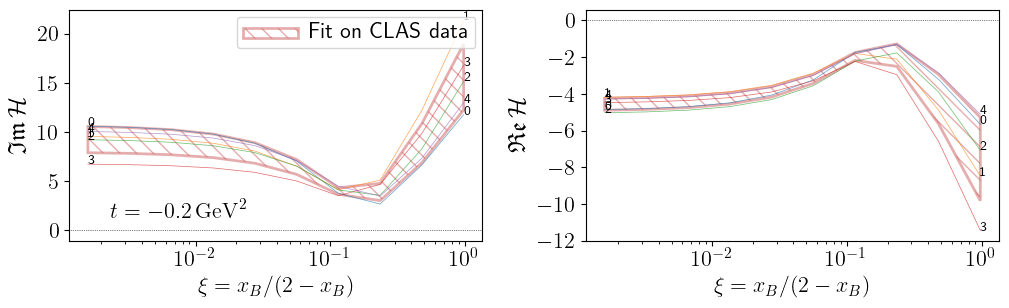

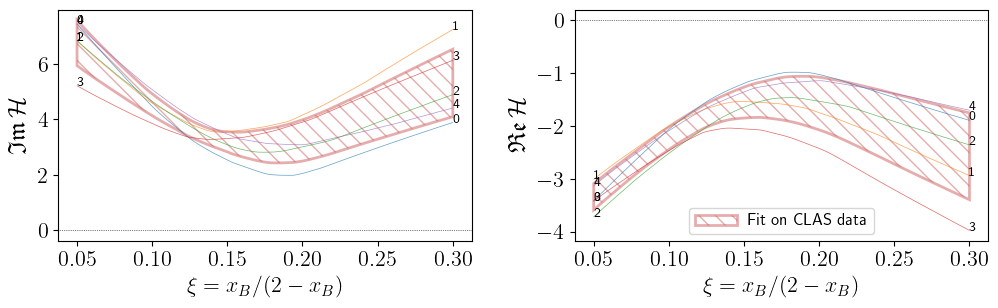

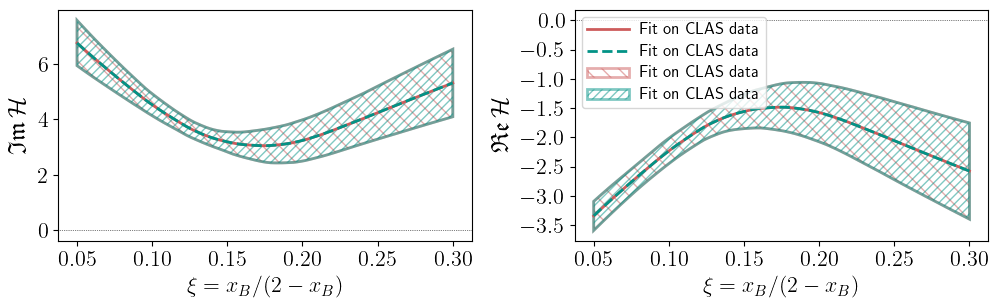

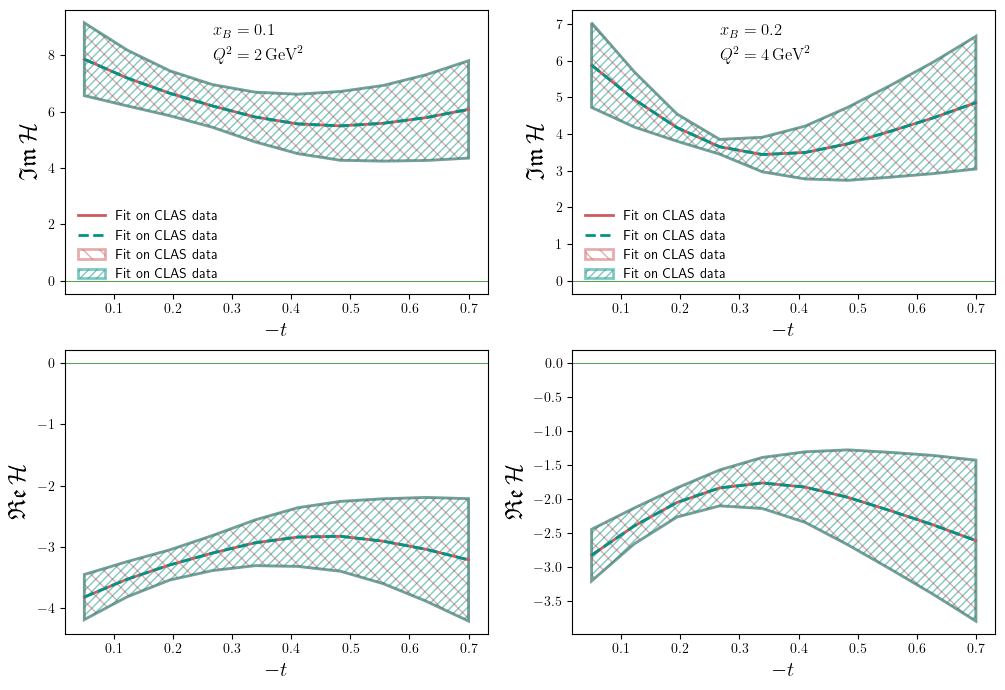

In [49]:
fig = gplot.CFF3log(cffs=['ImH', 'ReH'],  mesh=th, bands=[th], tval=-0.2)
fig = gplot.CFF3(cffs=['ImH', 'ReH'],  mesh=th, bands=[th])
fig = gplot.CFF3(cffs=['ImH', 'ReH'],  lines=[th, th], bands=[th, th])
fig = gplot.CFFt(cffs=['ImH', 'ReH'],  lines=[th, th], bands=[th, th])

In [50]:
th2 = NNTest(output_layer=['ImH', 'ReH', 'ImE', 'ReE']) 

In [53]:
f = g.fitter.NeuralFitter(fitpoints, th2, nnets=5, nbatch=10, batchlen=2, regularization='L2', lx_lambda=0.001)
f.fit()


Epoch   2: train error = 8.9231 test error = 7.8966 -
Epoch   4: train error = 8.7484 test error = 7.6883 -
Epoch   6: train error = 8.4966 test error = 7.3945 -
Epoch   8: train error = 8.1454 test error = 6.9950 -
Epoch  10: train error = 7.6617 test error = 6.4348 -
Epoch  12: train error = 6.8926 test error = 5.5337 -
Epoch  14: train error = 5.5738 test error = 4.1093 -
Epoch  16: train error = 3.5840 test error = 2.7328 -
Epoch  18: train error = 2.7536 test error = 2.5827 -
Epoch  20: train error = 1.9541 test error = 2.2016 -Net 0 --> test_err = 2.2015920243954756

Epoch   2: train error = 10.0164 test error = 8.3420 -
Epoch   4: train error = 9.8887 test error = 8.2288 -
Epoch   6: train error = 9.7284 test error = 8.0578 -
Epoch   8: train error = 9.5261 test error = 7.8457 -
Epoch  10: train error = 9.2841 test error = 7.5913 -
Epoch  12: train error = 8.9759 test error = 7.1984 -
Epoch  14: train error = 8.4654 test error = 6.5004 -
Epoch  16: train error = 7.5155 test err

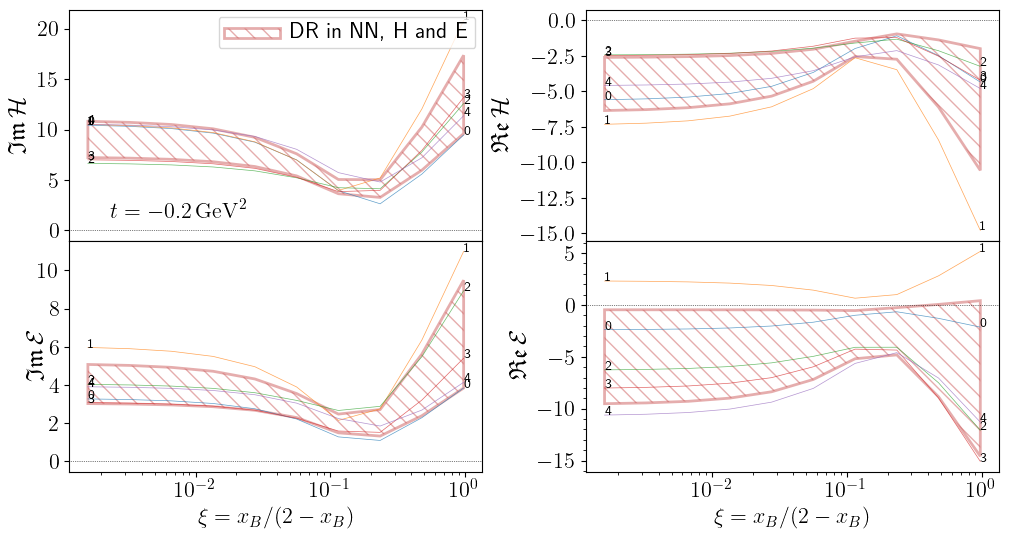

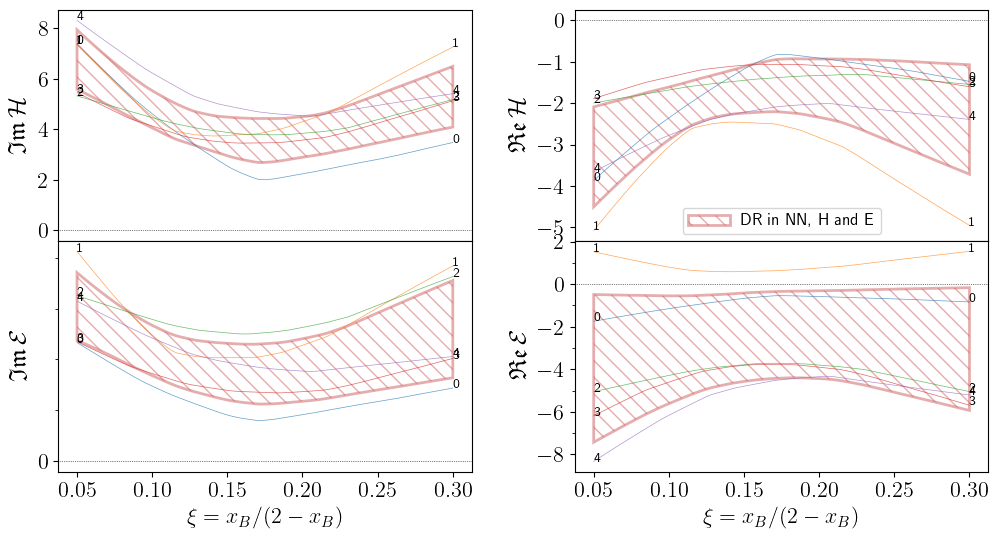

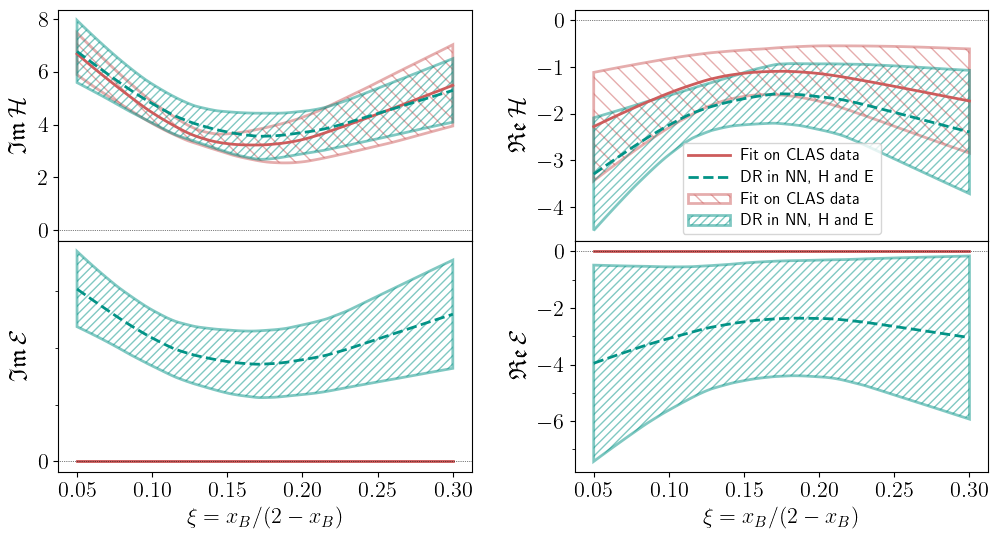

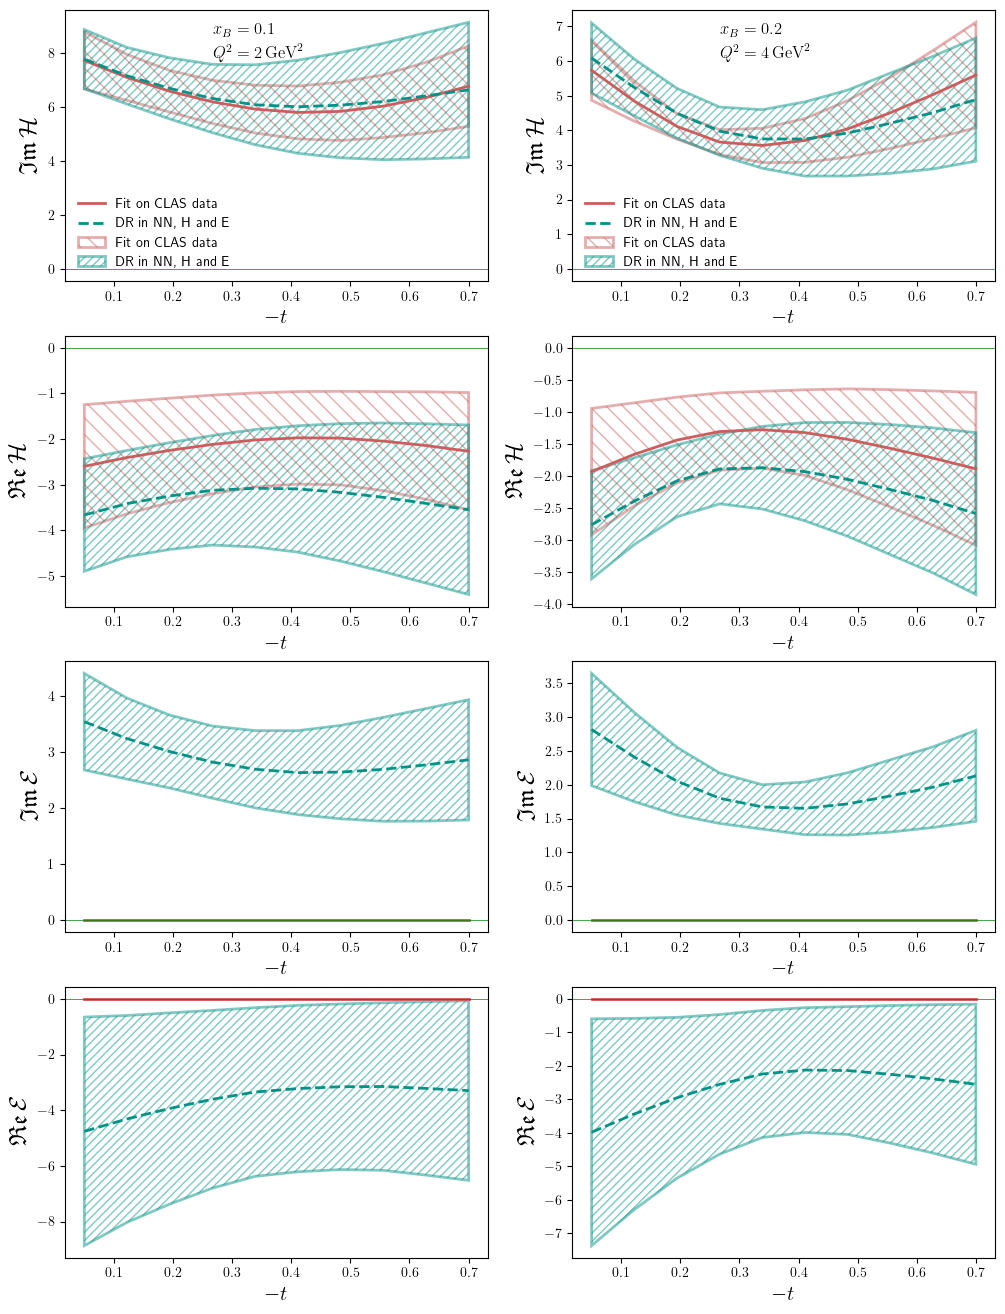

In [54]:
th2.name = "DR in NN, H and E"
fig = gplot.CFF3log(cffs=['ImH', 'ReH', 'ImE', 'ReE'],  mesh=th2, bands=[th2], tval=-0.2)
fig = gplot.CFF3(cffs=['ImH', 'ReH', 'ImE', 'ReE'],  mesh=th2, bands=[th2])
fig = gplot.CFF3(cffs=['ImH', 'ReH', 'ImE', 'ReE'],  lines=[th, th2], bands=[th, th2])
fig = gplot.CFFt(cffs=['ImH', 'ReH', 'ImE', 'ReE'],  lines=[th, th2], bands=[th, th2])

In [55]:
th2.chisq(fitpoints)

(np.float64(132.28830743899857), 172, np.float64(0.9891539195597604))

## Custom NN

In [ ]:
import torch.nn as nn
class CustomNetwork(nn.Module):
    def __init__(self):
        super(CustomNetwork, self).__init__()

        # Define the layers for the network
        self.n1 = nn.Linear(2, 20)  # 2 input features, 12 hidden units
        self.n2 = nn.Linear(20, 25)  # 12 hidden units, 17 hidden units
        self.n3 = nn.Linear(25, 1)  # 7 hidden units, 1 output features
        
        self.n1p = nn.Linear(1, 7)  # 2 input features, 12 hidden units
        self.n2p = nn.Linear(7, 5)  # 12 hidden units, 17 hidden units
        self.n3p = nn.Linear(5, 1)  # 17 hidden units, 1 output features

    def forward(self, x):
        
       
        x0 = x
        
        # Build Im network
        x = torch.relu(self.n1(x0))
        x = torch.relu(self.n2(x))
        output1 = self.n3(x)
        
        # Build D network
        # build the input tensor
        x0_1 = torch.cat((x0[:,1].unsqueeze(1),), dim=0)
       
        x2 = torch.relu(self.n1p(x0_1))
        x2 = torch.relu(self.n2p(x2))
        output2 = self.n3p(x2)
        
        #concatenate outputs
        output = torch.cat((output1, output2), dim=1)
       
        return output 

### Create the class inheriting from DispersionCFF

In [57]:
class NNTest_DR(g.model.NeuralModel_DR, g.eff.DipoleEFF, g.dvcs.BMK, g.cff.DispersionCFF):
    
    def build_net(self):
        '''Overriding the default architecture and optimizer'''
        nn_model = CustomNetwork()
        optimizer = torch.optim.Rprop(nn_model.parameters(),
                lr=0.01)
        return nn_model, optimizer
    
    def subtraction(self, pt): #This should use the NN, the real part will be calculated by the CFF_Dispersion methods
        """Subtraction constant."""
        #refer to the location of D in output layer (defined in the next cell)
        return self.cffs(1, pt, xi)
    
    def ImH(self, pt, xi=0) -> float:
        """Return Im(CFF H) for kinematic point."""
        #refer to the location of Im H in output layer (defined in the next cell)
        return self.cffs(0, pt, xi)
    
    def ImE(self, pt, xi=0):
        """Return Im(CFF E) for kinematic point."""
        return self.zero(pt)
    
    def ImHt(self, pt, xi=0):
        """Return Im(CFF Ht) for kinematic point."""
        return self.zero(pt)
    
    def ImEt(self, pt, xi=0):
        """Return Im(CFF Et) for kinematic point."""
        return self.zero(pt)

In [58]:
th2 = NNTest_DR(output_layer=['ImH', 'D'])#'ImH', 'ReH', 'ImE', 'ReE', 'ImHt', 'ReHt', 'ImEt', 'ReEt'])#

In [59]:
import time
t0 = time.time()

f = g.fitter.NeuralFitter(fitpoints, th2, nnets=10, nbatch=10, batchlen=2, regularization='L2', lx_lambda=0.0001)
f.fit()
#torch.save(th2.nets, 'Test_dataset2_nets.tar')

t1 = time.time()
# time in minutes
print(f"Total time: {(t1 - t0) / 60:.2f} minutes")



Epoch   2: train error = 8.0015 test error = 6.8910 -
Epoch   4: train error = 6.7962 test error = 5.5245 -
Epoch   6: train error = 5.2547 test error = 3.2933 -
Epoch   8: train error = 3.0356 test error = 1.6952 -
Epoch  10: train error = 2.1504 test error = 3.1373 +
Epoch  12: train error = 1.7440 test error = 1.4897 -
Epoch  14: train error = 1.6237 test error = 1.5657 +
Epoch  16: train error = 1.4831 test error = 1.3978 -
Epoch  18: train error = 1.3716 test error = 1.2018 -
Epoch  20: train error = 1.2968 test error = 1.1241 -Net 0 --> test_err = 1.12405546933288

Epoch   2: train error = 8.8722 test error = 8.4441 -
Epoch   4: train error = 7.4719 test error = 7.6732 -
Epoch   6: train error = 6.1759 test error = 6.2395 -
Epoch   8: train error = 4.1332 test error = 3.6858 -
Epoch  10: train error = 2.5434 test error = 1.7261 -
Epoch  12: train error = 2.0706 test error = 1.6541 -
Epoch  14: train error = 1.6115 test error = 1.0947 -
Epoch  16: train error = 1.3351 test error 

In [60]:
th2.chisq(fitpoints)

(np.float64(65.93948152986569), 172, np.float64(0.9999999999999886))

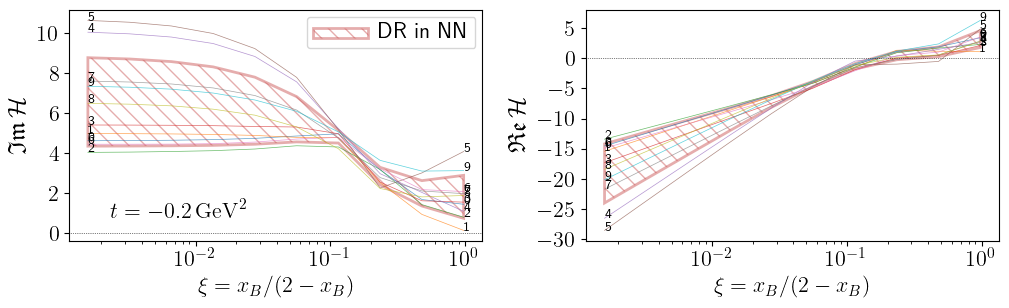

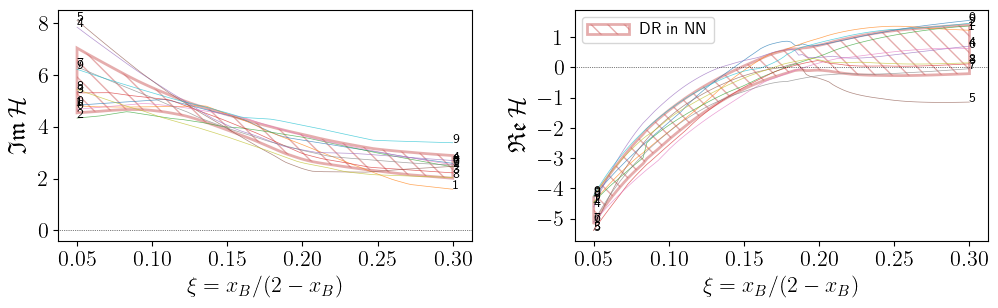

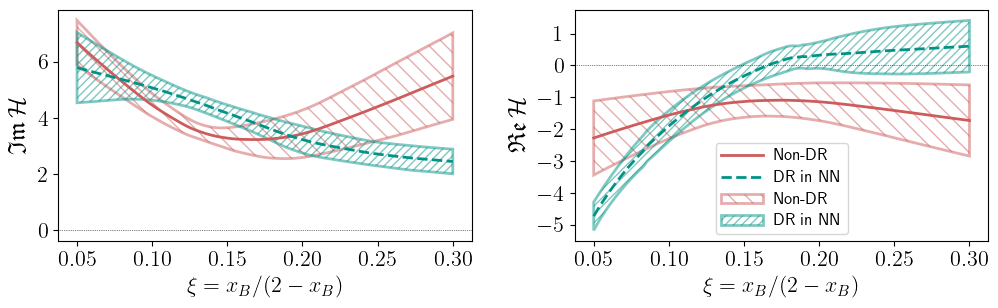

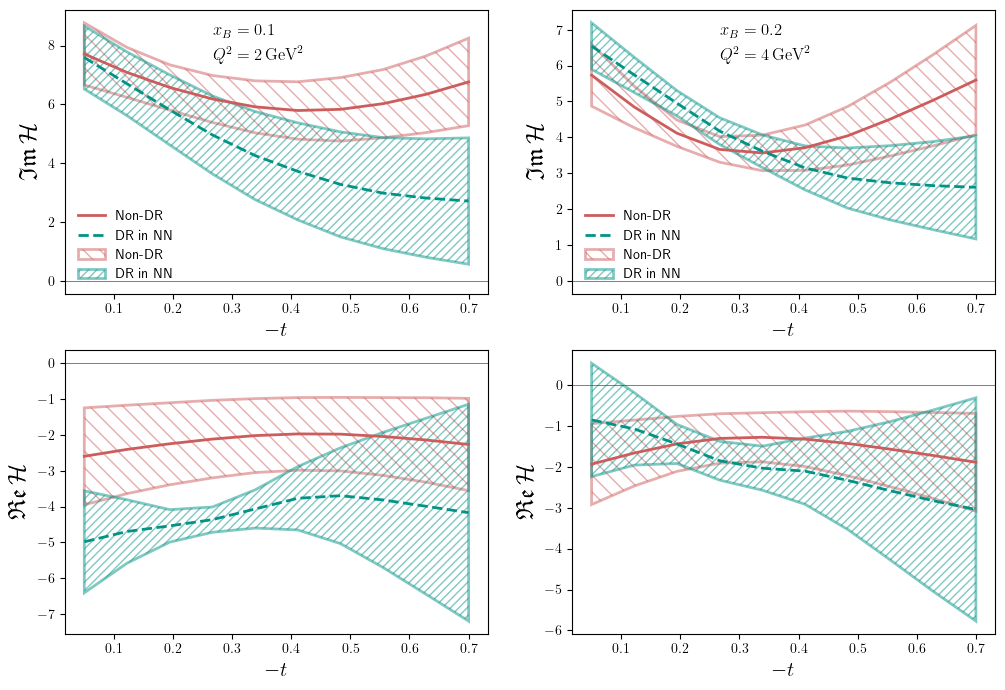

In [61]:
th.name = "Non-DR"
th2.name = "DR in NN"
fig = gplot.CFF3log(cffs=['ImH', 'ReH'],  mesh=th2, bands=[th2], tval=-0.2)
fig = gplot.CFF3(cffs=['ImH', 'ReH'],  mesh=th2, bands=[th2])
fig = gplot.CFF3(cffs=['ImH', 'ReH'],  lines=[th, th2], bands=[th, th2])
fig = gplot.CFFt(cffs=['ImH', 'ReH'],  lines=[th, th2], bands=[th, th2])

## Test with 4 CFFs

In [62]:
class CustomNetwork_4(nn.Module):
    def __init__(self):
        super(CustomNetwork_4, self).__init__()

        # Define the layers for the network
        self.n1 = nn.Linear(2, 20)  # 2 input features, 7 hidden units
        self.n2 = nn.Linear(20, 25)  # 7 hidden units, 7 hidden units
        self.n3 = nn.Linear(25, 2)  # 7 hidden units, 2 output features
        
        self.n1p = nn.Linear(1, 7)  # 2 input features, 7 hidden units
        self.n2p = nn.Linear(7, 5)  # 7 hidden units, 7 hidden units
        self.n3p = nn.Linear(5, 1)  # 7 hidden units, 2 output features

    def forward(self, x):
        
       
        x0 = x
        
        # Build Im network
        x = torch.relu(self.n1(x0))
        x = torch.relu(self.n2(x))
        output1 = self.n3(x)
        
        # Build D network
        # build the input tensor
        x0_1 = torch.cat((x0[:,1].unsqueeze(1),), dim=0)
       
        x2 = torch.relu(self.n1p(x0_1))
        x2 = torch.relu(self.n2p(x2))
        output2 = self.n3p(x2)
        
        #concatenate outputs
        output = torch.cat((output1, output2), dim=1)
       
        return output 

In [63]:
class NNTest_DR_4(g.model.NeuralModel_DR, g.eff.DipoleEFF, g.dvcs.BM10, g.cff.DispersionCFF):
    
    def build_net(self):
        '''Overriding the default architecture and optimizer'''
        nn_model = CustomNetwork_4()
        optimizer = torch.optim.Rprop(nn_model.parameters(),
                lr=0.05)
        return nn_model, optimizer
    
    def subtraction(self, pt): #This should use the NN, the real part will be calculated by the CFF_Dispersion methods
        """Subtraction constant."""
        #print("I am here in D")
        #refer to the location of D in output layer (defined in the next cell)
        return self.cffs(2, pt, xi)
    
    def ImH(self, pt, xi=0) -> float:
        """Return Im(CFF H) for kinematic point."""
        #refer to the location of Im H in output layer (defined in the next cell)
        return self.cffs(0, pt, xi)
    
    def ImE(self, pt, xi=0):
        """Return Im(CFF E) for kinematic point."""
        return self.cffs(1, pt, xi)
    
    def ImHt(self, pt, xi=0):
        """Return Im(CFF Ht) for kinematic point."""
        return self.zero(pt)
    
    def ImEt(self, pt, xi=0):
        """Return Im(CFF Et) for kinematic point."""
        return self.zero(pt)

In [64]:
th3 = NNTest_DR_4(output_layer=['ImH', 'ImE', 'D'])

In [65]:
f = g.fitter.NeuralFitter(fitpoints, th3, nnets=5, nbatch=10, batchlen=2, regularization='L2', lx_lambda=0.0001)
f.fit()
#torch.save(th3.nets, 'Test_dataset3_nets.tar')


Epoch   2: train error = 7.4471 test error = 4.8712 -
Epoch   4: train error = 2.7960 test error = 1.7087 -
Epoch   6: train error = 1.7053 test error = 1.4241 -
Epoch   8: train error = 1.6955 test error = 1.2871 -
Epoch  10: train error = 1.4589 test error = 1.4440 +
Epoch  12: train error = 1.2684 test error = 1.2344 -
Epoch  14: train error = 1.2104 test error = 1.3255 +
Epoch  16: train error = 1.1407 test error = 1.2499 +
Epoch  18: train error = 1.1067 test error = 1.3125 +
Epoch  20: train error = 1.0978 test error = 1.2857 +Net 0 --> test_err = 1.2343907729043846

Epoch   2: train error = 6.2044 test error = 4.2320 -
Epoch   4: train error = 2.8992 test error = 2.2423 -
Epoch   6: train error = 2.3555 test error = 1.9366 -
Epoch   8: train error = 1.9392 test error = 1.4173 -
Epoch  10: train error = 1.6027 test error = 1.3968 -
Epoch  12: train error = 1.3787 test error = 1.4111 +
Epoch  14: train error = 1.3277 test error = 1.4184 +
Epoch  16: train error = 1.2560 test erro

In [66]:
th3.chisq(fitpoints)

(np.float64(58.46575913188105), 172, np.float64(1.0))

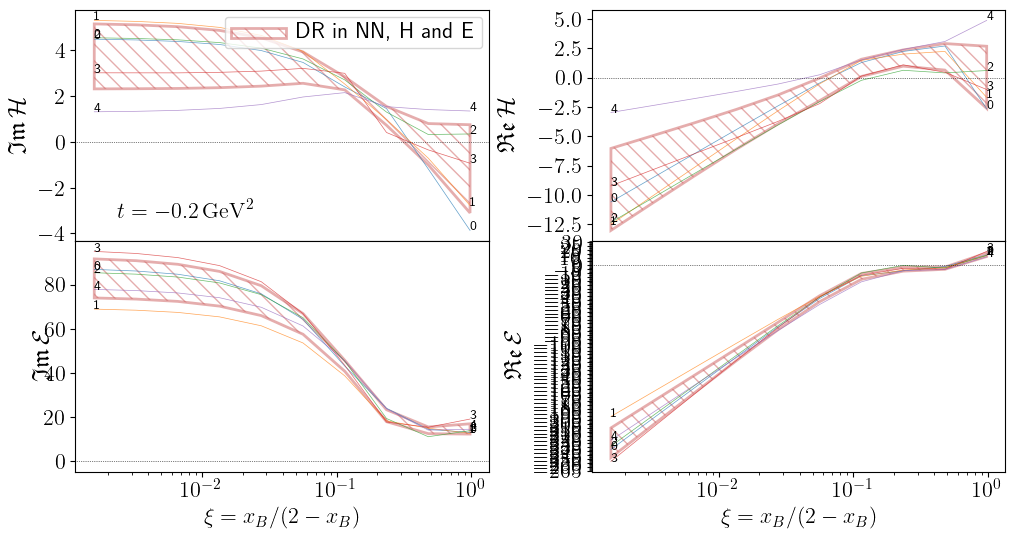

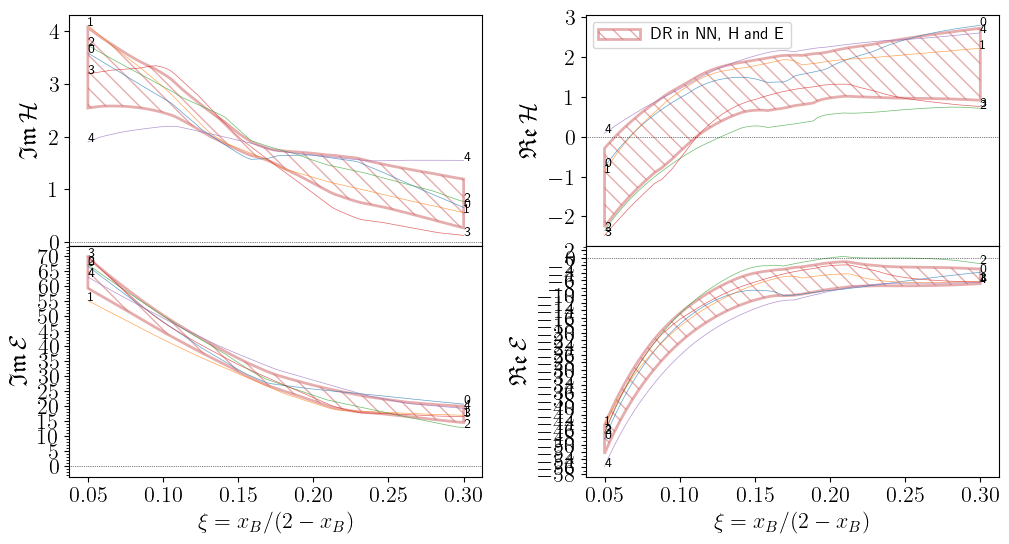

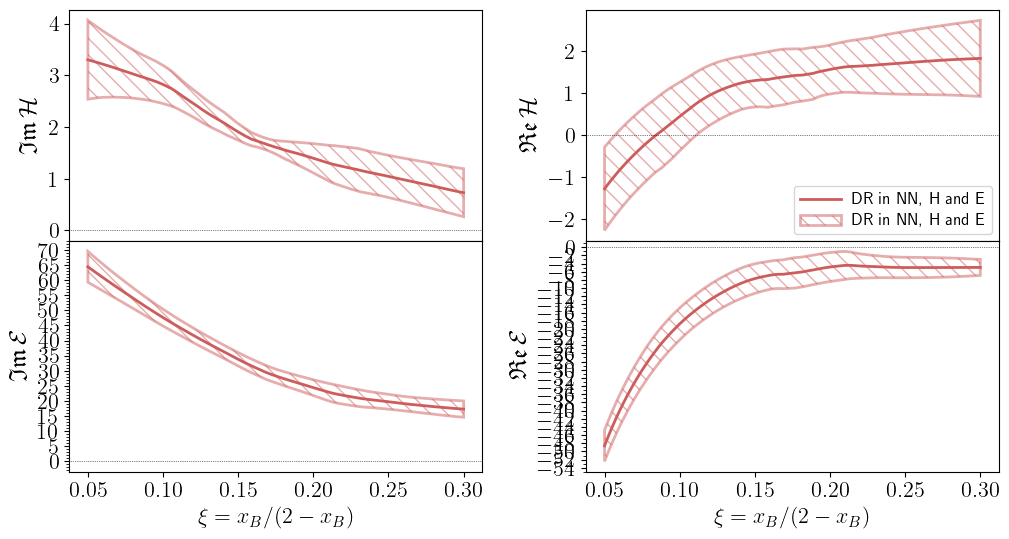

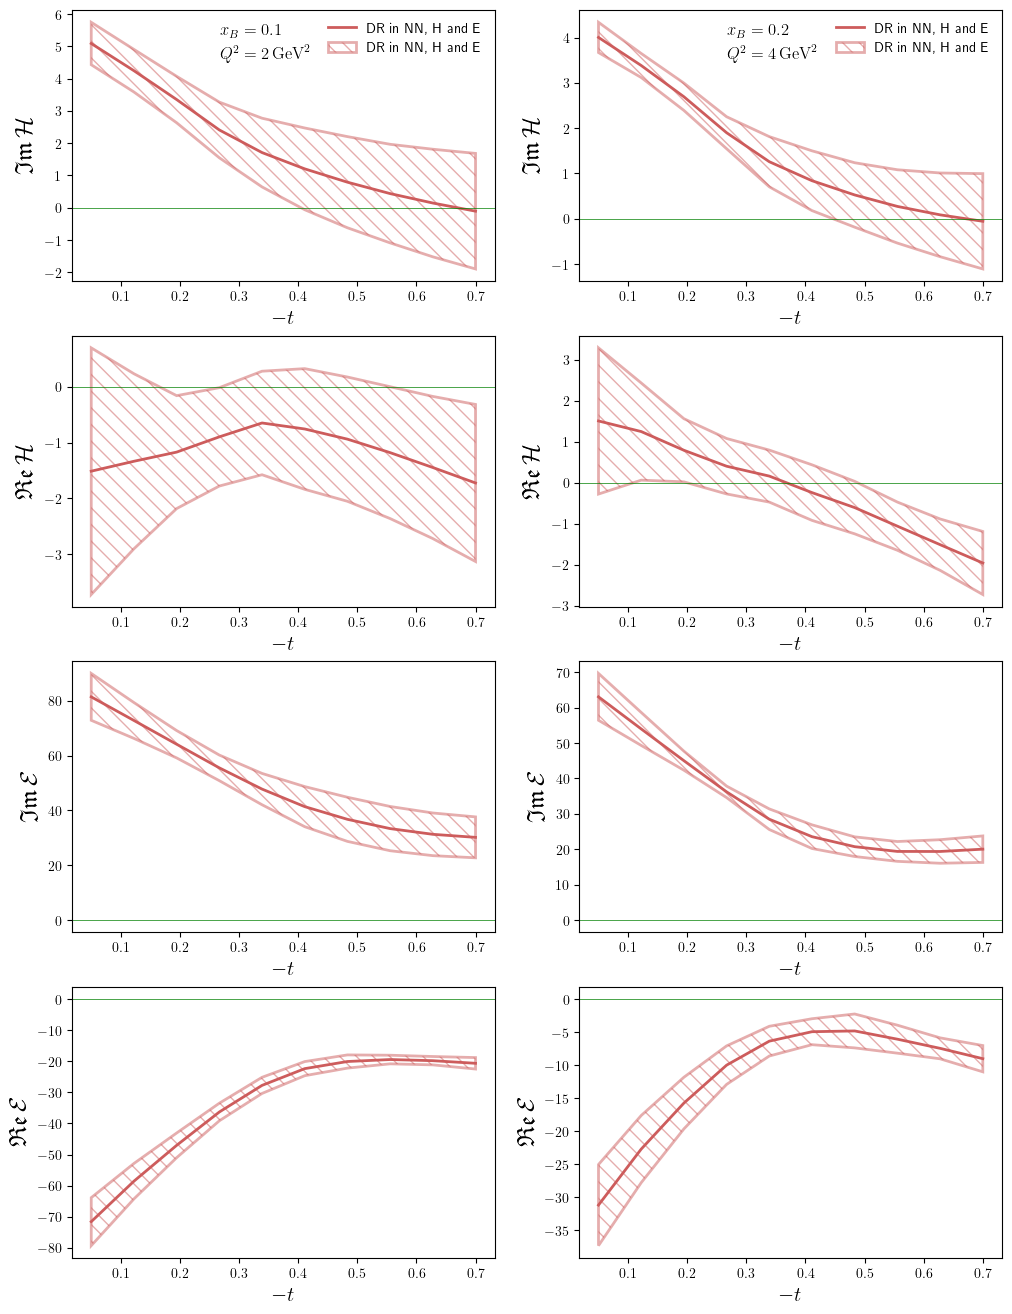

In [19]:
#th.name = "No DR"
#th2.name = "DR in NN"
th3.name = "DR in NN, H and E"
fig = gplot.CFF3log(cffs=['ImH', 'ReH', 'ImE', 'ReE'],  mesh=th3, bands=[th3], tval=-0.2)
fig = gplot.CFF3(cffs=['ImH', 'ReH', 'ImE', 'ReE'],  mesh=th3, bands=[th3])
fig = gplot.CFF3(cffs=['ImH', 'ReH', 'ImE', 'ReE'],  lines=[th3], bands=[th3])  #lines=[th, th2, th3], bands=[th, th2, th3]
fig = gplot.CFFt(cffs=['ImH', 'ReH', 'ImE', 'ReE'],  lines=[th3], bands=[th3])  #lines=[th, th2, th3], bands=[th, th2, th3]

### Describing CLAS data of 2015

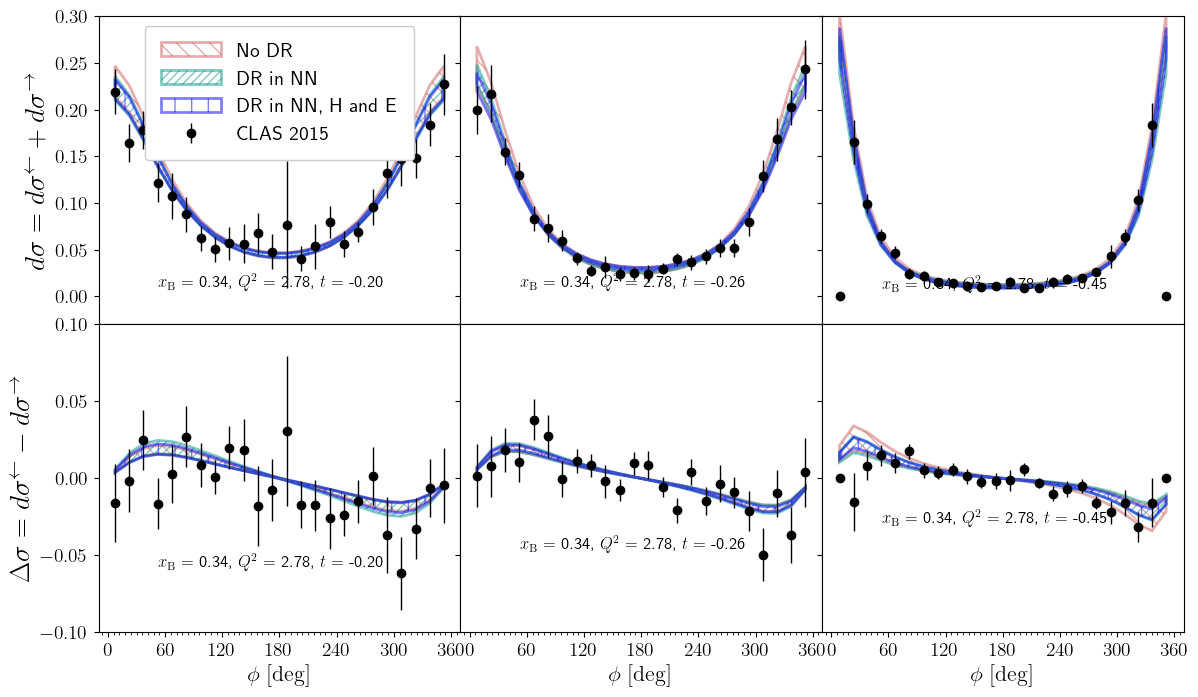

In [ ]:
fig = plots.CLAS15phi(bands=[th,th2,th3])

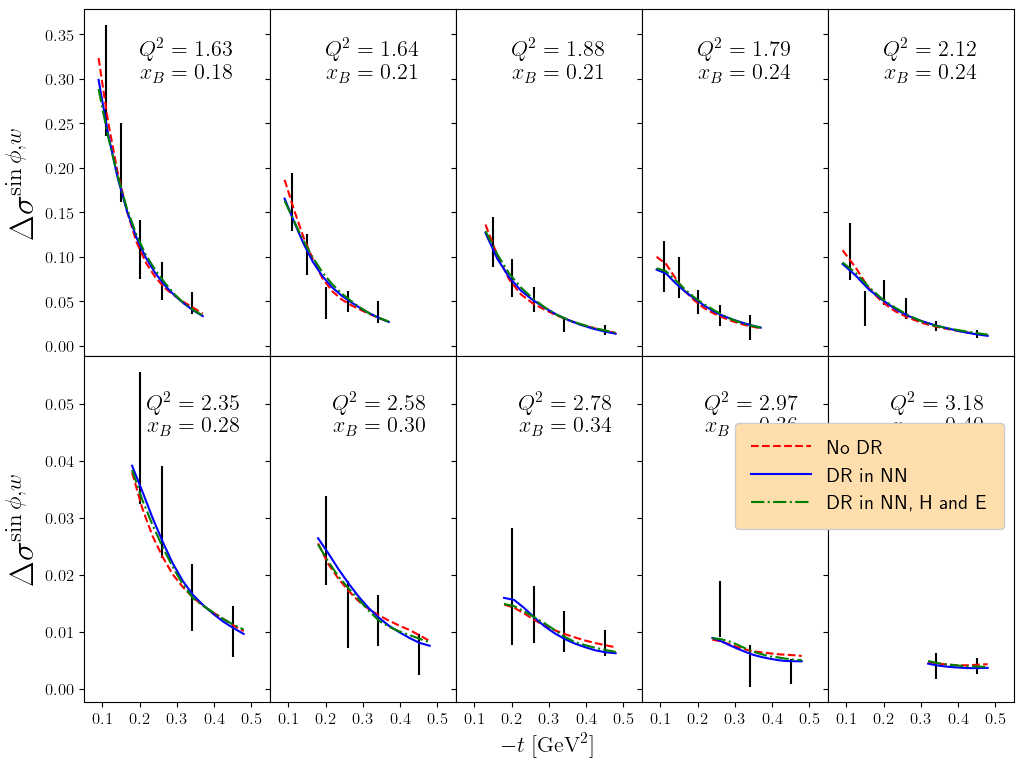

In [ ]:
fig = gplot.CLAS15xs(lines=[th,th2,th3])

## D-term using NN

In [ ]:
import random
ptts = []
tm_list = np.linspace(0.1, 0.5, 10)#[0.1, 0.2, 0.3, 0.4]

for tm in tm_list:
    #rndm_idx = random.randint(0, len(tm_list)-1) # take some random point and set/change -t
    ptb = g.dset[102][0].copy()  
    ptb.t = -tm
    ptb.tm = tm
    th15.prepare(ptb)
    ptts.append(ptb)


print(ptts)

[DataPoint: XUUw = 1.437, DataPoint: XUUw = 1.437, DataPoint: XUUw = 1.437, DataPoint: XUUw = 1.437, DataPoint: XUUw = 1.437, DataPoint: XUUw = 1.437, DataPoint: XUUw = 1.437, DataPoint: XUUw = 1.437, DataPoint: XUUw = 1.437, DataPoint: XUUw = 1.437]


In [ ]:
th2.name = "DR in NN whit 2 CFFs"
th3.name = "DR in NN with 4 CFFs"

In [ ]:
D = []
std_values = [] #!
net_indices = [] #!
for th in [th2, th3]: #[th2]: 
    print("\n---- [{} - {}] ----".format(th.name, th.description))
    A = []
    for pt in ptts[::-1]:
        Ds = []
        for i, net in enumerate(th.nets):  # Loop over neural networks
            th.nn_model, th.nn_mean, th.nn_std = net  # Assign neural net parameters
            
            Ds.append(float(th.m.subtraction(pt).detach().numpy()*18./25.))
            #print(float(-th.m.subtraction(pt).detach().numpy()*18./25.))
            th.cffs_evaluated = False
        net_indices.append(i)
        #for k in range(len(th.m.nets)):
            #th.m.parameters['nnet'] = k
            # NOTE: subtraction in code is equal to -\Delta(t) !
            #Ds.append(-th.m.subtraction(pt).detach().numpy()*18./25.) 
            #print(-th.m.subtraction(pt).detach().numpy()*18./25.)
        Ds = np.array(Ds)
        D_std = Ds.std() #!
        std_values.append(D_std) #!

        print("{}, {}: {} +- {}".format(pt.xB, pt.t, Ds.mean(), Ds.std()))
        A.append((pt.tm, Ds.mean(), Ds.std()))
    th.m.parameters['nnet'] = 'ALL'    
    D.append(A)


---- [DR in NN whit 2 CFFs - N/A] ----
0.185, -0.5: -0.4780326887965202 +- 1.4773601863785928
0.185, -0.4555555555555556: -0.6362771719694138 +- 1.329302059053012
0.185, -0.4111111111111111: -0.7882916733622551 +- 1.1722124111284176
0.185, -0.3666666666666667: -0.882777250930667 +- 1.132817425052218
0.185, -0.32222222222222224: -0.9457036584615708 +- 1.1563550731254926
0.185, -0.2777777777777778: -0.9580904725007713 +- 1.1988336336453773
0.185, -0.23333333333333334: -1.1669922083616258 +- 1.295013604717738
0.185, -0.18888888888888888: -1.552262084186077 +- 1.4937359475849563
0.185, -0.14444444444444446: -1.970478953793645 +- 1.7274276258180312
0.185, -0.1: -2.383175742998719 +- 2.0401277230855293

---- [DR in NN with 4 CFFs - N/A] ----
0.185, -0.5: -0.8183236420154572 +- 1.2069137187002965
0.185, -0.4555555555555556: -0.8466813564300537 +- 1.0012454716220371
0.185, -0.4111111111111111: -0.8918539864942432 +- 0.7746504280677209
0.185, -0.3666666666666667: -0.9252635538578033 +- 0.56977

/var/folders/qr/2k2591d90wjb4sqtmlttw7r40000gq/T/ipykernel_55934/1427647854.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ds.append(float(th.m.subtraction(pt).detach().numpy()*18./25.))


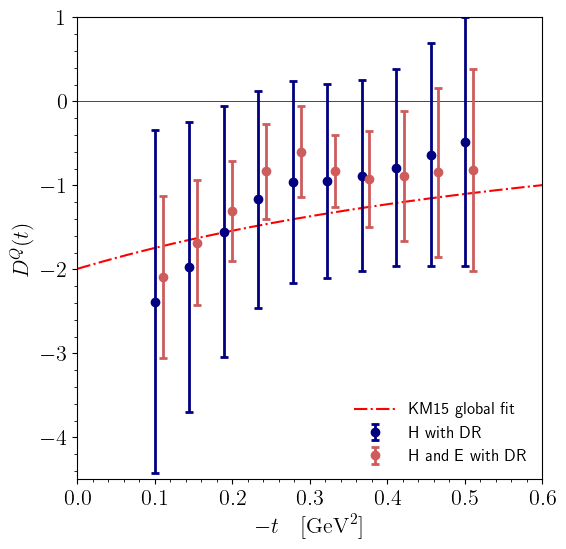

In [ ]:
NPTS = 20
ts = np.linspace(0, 0.6, NPTS)
KMS = np.array([-(18./25.)*2.768/(1.+tm/1.204**2)**2 for tm in ts])
CDS = np.array(D[0])
CADS = np.array(D[1])
fig, ax = plt.subplots(1, 1,  figsize=[6,6])
ax.axhline(y=0, linewidth=0.5, color='k')  # y=0 thin line
ax.plot(ts, KMS, 'r-.', label='KM15 global fit')
ax.errorbar(CDS[:,0], CDS[:,1], CDS[:,2], linestyle='None', color='navy',
            elinewidth=2, capsize=3, capthick=2, marker='o', label='H with DR')
ax.errorbar(CADS[:,0,]+0.01, CADS[:,1], CADS[:,2], linestyle='None', elinewidth=2,
            capsize=3, capthick=2, marker='o', color='indianred', label='H and E with DR')

ax.set_xlim(0.0, 0.6)
ax.set_ylim(-4.5, 1)
ax.legend(loc=4, handlelength=2.5,
            prop=matplotlib.font_manager.FontProperties(size="large")
        ).draw_frame(0)
ax.set_xlabel(r'$-t \quad [{\rm GeV}^2]$', fontsize=16)
ax.set_ylabel(r'$D^{Q}(t)$', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
ax.xaxis.set_major_locator(
        matplotlib.ticker.MultipleLocator(0.1)) 
ax.xaxis.set_minor_locator(
        matplotlib.ticker.MultipleLocator(0.02)) 
ax.yaxis.set_major_locator(
        matplotlib.ticker.MultipleLocator(1.)) 
ax.yaxis.set_minor_locator(
        matplotlib.ticker.MultipleLocator(0.2)) 